In [1]:
model_name = "Original_Pretrained_R2plus1DMotionSegNet.pth"

# model_name = "dropout_v2_0_25_R2plus1DMotionSegNet.pth"
# model_name = "dropout_v3_0_10_R2plus1DMotionSegNet.pth"

In [2]:
import os
os.chdir("../..")
print(os.getcwd())

%config Completer.use_jedi = False

import SimpleITK as itk
from LabelFusion.wrapper import fuse_images

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
from src.utils.echo_utils import get2dPucks
from src.utils.camus_validate import cleanupSegmentation
from src.transform_utils import generate_2dmotion_field
from src.visualization_utils import categorical_dice
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.echonet_dataset import EDESpairs, EchoNetDynamicDataset

from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet

# v2 dropout (in place before motion heads, forgot to define in forward pass function, but still saw diff, weird.)
from src.model.dropout_v2_0_00_R2plus1D_18_MotionNet import dropout_v2_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_10_R2plus1D_18_MotionNet import dropout_v2_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_25_R2plus1D_18_MotionNet import dropout_v2_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_50_R2plus1D_18_MotionNet import dropout_v2_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_75_R2plus1D_18_MotionNet import dropout_v2_0_75_R2plus1D_18_MotionNet
# v3 dropout (one dropout layer defined in forward pass func, this should've been the correct way to do it.)
from src.model.dropout_v3_0_00_R2plus1D_18_MotionNet import dropout_v3_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_10_R2plus1D_18_MotionNet import dropout_v3_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_25_R2plus1D_18_MotionNet import dropout_v3_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_50_R2plus1D_18_MotionNet import dropout_v3_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_75_R2plus1D_18_MotionNet import dropout_v3_0_75_R2plus1D_18_MotionNet
# v4 dropout (4 dropout layers in different places in the forward func, I'm going to guess more "generalizable")
from src.model.dropout_v4_0_00_R2plus1D_18_MotionNet import dropout_v4_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_10_R2plus1D_18_MotionNet import dropout_v4_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_25_R2plus1D_18_MotionNet import dropout_v4_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_50_R2plus1D_18_MotionNet import dropout_v4_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_75_R2plus1D_18_MotionNet import dropout_v4_0_75_R2plus1D_18_MotionNet

# for finding lv seg borders
import cv2 as cv


# from src.visualization_utils import categorical_dice

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


batch_size = 4
num_workers = max(4, cpu_count()//2)


def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    print(f'worker_seed: {worker_seed}')
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}


with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

# full_dataset = EchoNetDynamicDataset(split='val', clip_length="full", subset_indices=valid_mask, period=1)
test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)
# random_test_dataset = EchoNetDynamicDataset(split='test', clip_length=32, raise_for_es_ed=True, period=1)

/home/wang/workspace/JupyterNoteBooksAll/fully-automated-multi-heartbeat-echocardiography-video-segmentation-and-motion-tracking


100%|██████████| 16/16 [00:01<00:00, 14.17it/s]


In [3]:
model_save_path = f"save_models/{model_name}"
    
if model_name == 'Original_Pretrained_R2plus1DMotionSegNet.pth':
    model_template_obj = R2plus1D_18_MotionNet()
elif model_name == 'dropout_v2_0_00_R2plus1DMotionSegNet.pth':
    model_template_obj = dropout_v2_0_00_R2plus1D_18_MotionNet()
elif model_name == 'dropout_v2_0_10_R2plus1DMotionSegNet.pth':
    model_template_obj = dropout_v2_0_10_R2plus1D_18_MotionNet()
elif model_name == 'dropout_v2_0_25_R2plus1DMotionSegNet.pth':
    model_template_obj = dropout_v2_0_25_R2plus1D_18_MotionNet()


elif model_name == "dropout_v3_0_00_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v3_0_00_R2plus1D_18_MotionNet()
elif model_name == "dropout_v3_0_10_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v3_0_10_R2plus1D_18_MotionNet()
elif model_name == "dropout_v3_0_25_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v3_0_25_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_00_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v4_0_00_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_10_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v4_0_10_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_25_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v4_0_25_R2plus1D_18_MotionNet()


model = torch.nn.DataParallel(model_template_obj)

model.to("cuda")
torch.cuda.empty_cache()
model.load_state_dict(torch.load(model_save_path)["model"])
print(f'{model_name} has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')
model.eval();

Original_Pretrained_R2plus1DMotionSegNet.pth has 31575731 parameters.


In [4]:
from src.strain import *

In [5]:
%matplotlib widget

In [6]:
N = 3
test_pat_index = 0

curr_clip_segmentations, curr_clip_motions, delta_ed_es, clip_index, ed_label, es_label = get_seg_and_warp_data(model = model,
                                                                                            test_dataset = test_dataset,
                                                                                            test_pat_index = test_pat_index)
    
ed_raw_seg_out = curr_clip_segmentations[:,0,...]

ed_one_hot_seg_out = one_hot(ed_raw_seg_out)


In [7]:
I = ed_one_hot_seg_out

I_regional_point_sets = image_to_regional_point_sets(I)

/home/wang/workspace/JupyterNoteBooksAll/fully-automated-multi-heartbeat-echocardiography-video-segmentation-and-motion-tracking/src/strain.py:1070: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  I_regional_point_sets = np.array(I_regional_point_sets)


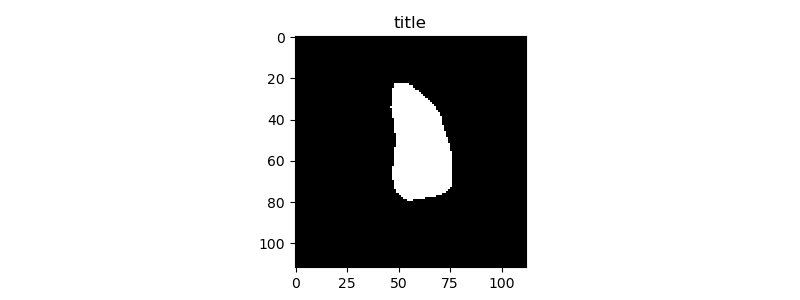

In [8]:
vis_single(I, cmap='gray')

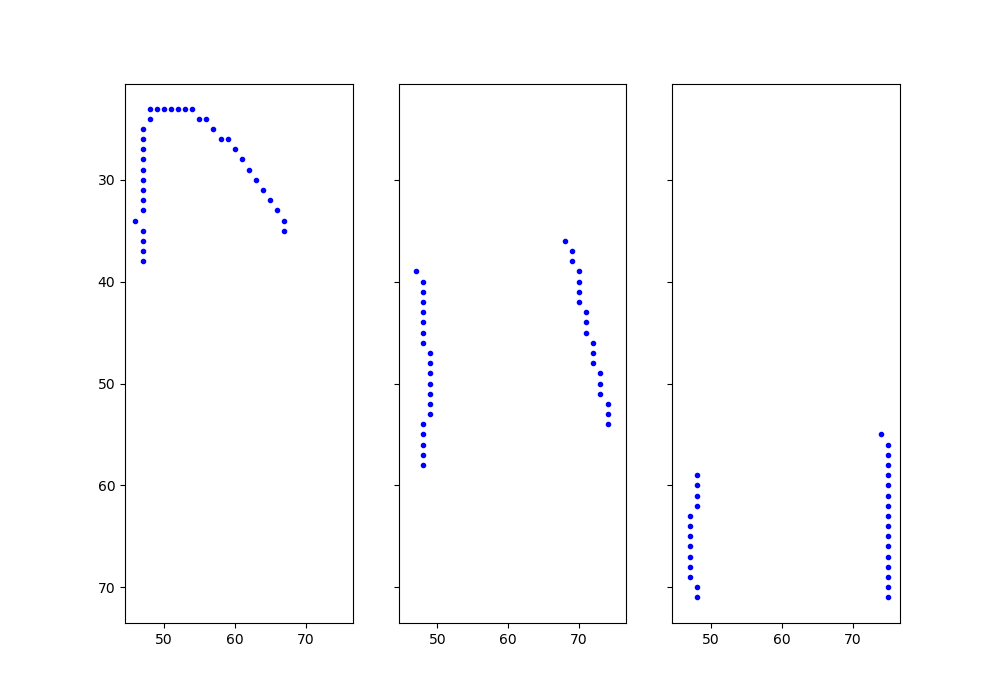

In [9]:
vis_three_point_sets(I_regional_point_sets)

In [10]:
for i in range(N):
    print(I_regional_point_sets[i].shape)

(36, 2)
(39, 2)
(30, 2)


## Warping the point set forward in time from frame `0` to frame `1` is easy. 
## Warping from frame `1` to further frames is difficult because we need to interpolate the vector fields from their integer locations to our frame `1` and beyond frames floating point positions

In [11]:
# def foo(coords, delta_ed_es, curr_clip_motions):
#     '''
#     input:
#         coords - (N, 2) ndarray not tensor
#         delta_ed_es - int
#         curr_clip_motions - (4, 32, 112, 112)
#     output:
#         coords_return - (delta_ed_es, N, 2)
#             stores the location of the point sets at every frame from 0 to delta_ed_es
#     '''
#     coords_return = None
#     in_coords_len = coords.shape[0]
    
#     for frame in range(delta_ed_es):
#         # first warp from ED -> ED+1
#         if frame == 0:
#             # warp forward all the current points
#             coords_1 = []
#             for _ in range(len(coords)):
#                 pair = coords[_]

#                 i_0,j_0 = pair[0],pair[1]

#                 # forward change in y
#                 delta_i = curr_clip_motions[1][frame][i_0][j_0]

#                 # forward change in x
#                 delta_j = curr_clip_motions[0][frame][i_0][j_0]

#                 i_1, j_1 = i_0 + delta_i , j_0 + delta_j

#                 coords_1.append([i_1, j_1])
#             # for second iteration
#             coords_return = coords_1
#         else:
#             # all other warps starting from ED+1 -> ED+2
#             # to final warp ED+(n-1) -> ED+n
#             # TODO
            

In [12]:
I_apical_point_set = I_regional_point_sets[0]

coords = I_apical_point_set

coords_multiple_frames = np.array([coords]).astype(float)

In [13]:
frame = 0

# warp forward all the current points
coords_1 = []
for _ in range(len(coords)):
    pair = coords[_]

    i_0,j_0 = pair[0],pair[1]

    # forward change in y
    delta_i = curr_clip_motions[1][frame][i_0][j_0]

    # forward change in x
    delta_j = curr_clip_motions[0][frame][i_0][j_0]

    i_1, j_1 = i_0 + delta_i , j_0 + delta_j
    
    # print(i_1, j_1)

    coords_1.append([i_1, j_1])

coords_1 = np.array(coords_1)

coords_multiple_frames = np.insert(coords_multiple_frames, 1, coords_1, axis=0)

coords_multiple_frames = coords_multiple_frames

In [14]:
coords_multiple_frames.shape

(2, 36, 2)

In [15]:
coords_multiple_frames[0][0], coords_multiple_frames[1][0]

(array([23., 48.]), array([23.02076343, 47.97884216]))

In [16]:
coords_multiple_frames[0][1], coords_multiple_frames[1][1]

(array([23., 49.]), array([23.02719518, 48.99810717]))

In [17]:
coords_multiple_frames[0][15], coords_multiple_frames[1][15]

(array([27., 47.]), array([27.03639373, 47.0468244 ]))

In [18]:
coords_multiple_frames.shape

(2, 36, 2)

## Now first warp is complete.
## Next, need to interpolate the subsequent vector field so that the warp can be applied to the current point positions

## Alternative approaches using mathematics established for solving other problems include: [SLERP](https://en.wikipedia.org/wiki/Slerp) and [Quarternions](https://en.wikipedia.org/wiki/Quaternion)
### [3blue1brown & BenEater's interactive tools](https://eater.net/quaternions) for understanding quarternions have been helpful, but I'm not sure how much time to put in for that 

## However, I have tried to understand them, and while I don't get them fully, I don't know if they have potential for solving this specific problem

In [19]:
from scipy.interpolate import interpn

In [20]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    # return(rho, phi)
    return np.vstack([rho, phi]).T

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    # return(x, y)
    return np.vstack([x, y]).T

In [21]:
def vec2pol(v):
    '''
    input:
        v - ((i, j), (del_i, del_j))
        magnitude of this vector is described by the |v| = sqrt(del_x^2 + del_y^2)
    output:
        v - ((i, j), (rho, theta))
    '''
    delta_x = v[1][1]
    delta_y = v[1][0]
    
    v[1] = cart2pol(delta_x, delta_y)
    return v

In [22]:
curr_clip_motions.shape

(4, 32, 112, 112)

In [23]:
# getting the forward vectors at frame = 1
motion_vectors = {}
frame = 1

for i in range(curr_clip_motions.shape[2]):
    for j in range(curr_clip_motions.shape[3]):
        
        if i not in motion_vectors:
            motion_vectors[i] = {}

        motion_vectors[i][j] = [curr_clip_motions[0][frame][i][j], curr_clip_motions[1][frame][i][j]]
        
        # v = [[i,j], [curr_clip_motions[0][frame][i][j], curr_clip_motions[1][frame][i][j]]]
        # motion_vectors.append(v)

# motion_vectors = np.array(motion_vectors)

In [24]:
# for i in range(len(motion_vectors)):
#     motion_vectors[i] = vec2pol(motion_vectors[i])

In [25]:
# motion_vectors[0]

In [26]:
# motion_vectors.shape

In [27]:
point = coords_multiple_frames[1][0] # one point at frame 1, need to now warp using frame 1 vectors
point

array([23.02076343, 47.97884216])

In [28]:
# need vectors at this i,j
# first get the 4 vectors surrounding this vector
inted_i, inted_j = int(point[0]), int(point[1])
surround_vectors = [ [inted_i, inted_j],
                     [inted_i, inted_j+1],
                     [inted_i+1, inted_j],
                     [inted_i+1, inted_j+1] ]

# get the distance from the current point to each surrounding vector
def get_distance(x2,y2,x1,y1):
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def distance_btwn_points(p0,p1):
    x2 = p1[0]
    y2 = p1[1]
    x1 = p0[0]
    y1 = p0[1]
    return get_distance(x2,y2,x1,y1)
    

distances = []
p0 = ij_to_xy(point)
for i in range(len(surround_vectors)):
    i_ = surround_vectors[i][0]
    j_ = surround_vectors[i][1]
    
    p1 = ij_to_xy([i_, j_])
    
    distances.append(distance_btwn_points(p0,p1))

In [29]:
surround_vectors

[[23, 47], [23, 48], [24, 47], [24, 48]]

In [30]:
distances

[0.9790623543612463,
 0.02964412692312461,
 1.3845707754530165,
 0.9794651156484416]

In [31]:
distances = distances / np.sum(distances)

In [32]:
distances

array([0.29028673, 0.00878932, 0.4105178 , 0.29040615])

In [33]:
np.sum(distances)

1.0

In [34]:
weights = 1.0 - distances
weights

array([0.70971327, 0.99121068, 0.5894822 , 0.70959385])

In [35]:
weights = weights / np.sum(weights)
weights

array([0.23657109, 0.33040356, 0.19649407, 0.23653128])

In [36]:
np.sum(weights)

1.0

In [37]:
# assuming our weights is correct, let us apply the interpolation on the vectors
surround_vectors_with_displacement_in_cart = []
for i,j in surround_vectors:
    
    forward_x = motion_vectors[i][j][0]
    forward_y = motion_vectors[i][j][1]
    
    forward_i = forward_y
    forward_j = forward_x
    
    surround_vectors_with_displacement_in_cart.append( [[i,j],[forward_i, forward_j]] )
    
surround_vectors_with_displacement_in_cart = np.array(surround_vectors_with_displacement_in_cart)

In [38]:
surround_vectors_with_displacement_in_cart

array([[[ 2.30000000e+01,  4.70000000e+01],
        [ 2.39035543e-02, -3.85992154e-02]],

       [[ 2.30000000e+01,  4.80000000e+01],
        [ 1.26686618e-02, -2.62219310e-02]],

       [[ 2.40000000e+01,  4.70000000e+01],
        [ 3.01304422e-02, -4.47503254e-02]],

       [[ 2.40000000e+01,  4.80000000e+01],
        [ 4.02380340e-02,  1.80606991e-02]]])

In [39]:
surround_vectors_with_displacement_in_cart.shape

(4, 2, 2)

In [40]:
# convert into polar
surround_vectors_with_displacement_in_polar = []
for v in surround_vectors_with_displacement_in_cart:
    surround_vectors_with_displacement_in_polar.append(vec2pol(v))
    
surround_vectors_with_displacement_in_polar = np.array(surround_vectors_with_displacement_in_polar)

In [41]:
surround_vectors_with_displacement_in_polar_just_rho_theta = surround_vectors_with_displacement_in_polar[: , 1, ...]

In [42]:
surround_vectors_with_displacement_in_polar_just_rho_theta, surround_vectors_with_displacement_in_polar_just_rho_theta.shape

(array([[0.04540131, 2.58712032],
        [0.02912189, 2.69153004],
        [0.05394845, 2.54901105],
        [0.04410542, 1.1489021 ]]),
 (4, 2))

In [43]:
weights, weights.shape

(array([0.23657109, 0.33040356, 0.19649407, 0.23653128]), (4,))

In [44]:
# do linear interpolation on the rho, theta (leave the i,j coords alone!)
def linear_interp(weights, vectors):
    x = []
    y = []
    for i,v in enumerate(vectors):
        x.append(weights[i]*v[0])
        y.append(weights[i]*v[1])
    return np.array([np.sum(x), np.sum(y)])

In [45]:
point_displacement_in_polar = linear_interp(weights, surround_vectors_with_displacement_in_polar_just_rho_theta)

point_displacement_in_cart =  pol2cart(point_displacement_in_polar[0], point_displacement_in_polar[1])[0] # this will be in xy
point_displacement_in_cart = ij_to_xy(point_displacement_in_cart) # now in ij

In [46]:
point_displacement_in_cart

array([ 0.03157686, -0.02676728])

In [47]:
# i,j rooted at the old point
# delta_i, delta_j is the new interpolated displacement 
new_vector = np.array([point, point_displacement_in_cart])

In [48]:
new_vector

array([[ 2.30207634e+01,  4.79788422e+01],
       [ 3.15768613e-02, -2.67672824e-02]])

In [49]:
# assuming I didn't fuck something up, these are our delta_i, delta_j (maybe they are instead delta_x, delta_y)
# create new point (frame 1 point + displacement we just created)

new_point = new_vector[0] + new_vector[1]

In [50]:
new_point

array([23.05234029, 47.95207488])

## Well, let's first see if our vector interpolation is plausible

In [64]:
def check_interpolate(surround_vectors, new_vector):
    '''
    assume data format: ((i, j), (delta_i, delta_j)) for all vectors
    
    surround_vectors (4,2,2)
    new_vector (2,2)

    always the headeache of knowing
    x = j
    y = i

    '''
    
    x = surround_vectors[:, 0, 1]
    y = surround_vectors[:, 0, 0]
    
    x_1 = new_vector[0, 1]
    y_1 = new_vector[0, 0]
    
    delta_x = surround_vectors[:, 1, 1]
    delta_y = surround_vectors[:, 1, 0]
    
    delta_x_1 = new_vector[1, 1]
    delta_y_1 = new_vector[1, 0]
    
    plt.figure()
    plt.quiver(x, y, delta_x, delta_y, color='k', linewidth=0.7)
    plt.quiver(x_1, y_1, delta_x_1, delta_y_1, color='b', linewidth=0.7)
    plt.show()

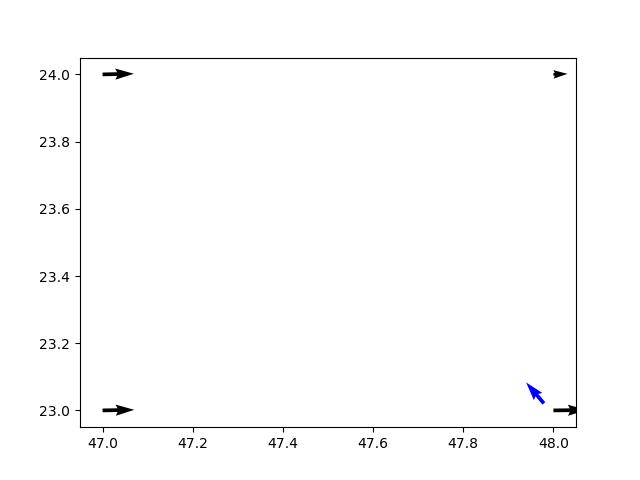

In [65]:
check_interpolate(surround_vectors_with_displacement_in_cart, new_vector)

# BE CAREFUL: your vectors are describing forward X,Y direction but you are storing your vectors in i,j format!!!

## we have vectors at (i,j, $\rho$, $\theta$) describing forward x,y motion of point at i,j
## i,j are integer values

## 